# 00. 라이브러리 로드

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow_datasets as tfds
import tensorflow as tf

# 01. GPT 구조 함수 정의 (트랜스포머와 비교)

### Transformer  
├── **Input Processing**  
│   ├── Positional Encoding Layer  
│   ├── Padding Mask  
│   └── Look-ahead Mask  
├── **Attention Mechanism**  
│   ├── Scaled Dot Product Attention  
│   └── Multi-Head Attention  
├── **Encoder**  
│   ├── Encoder Layer  
│   │   ├── Multi-Head Attention (Self-Attention)  
│   │   ├── Feed Forward Network  
│   │   └── Add & Norm (Residual + Layer Normalization)  
│   └── Stacking Encoder Layers  
├── **Decoder**  
│   ├── Decoder Layer  
│   │   ├── Masked Multi-Head Attention (Self-Attention)  
│   │   ├── Encoder-Decoder Attention  
│   │   ├── Feed Forward Network  
│   │   └── Add & Norm (Residual + Layer Normalization)  
│   └── Stacking Decoder Layers  
└── **Output Layer**  
    └── Final Linear Layer + Softmax  

### GPT-1
├── **Input Processing**  
│   ├── Token Embedding  
│   ├── Positional Embedding  
│   └── Look-ahead Mask 
├── **Decoder**    
│   ├── Decoder Layer   
│   │   ├── Masked Multi-Head Attention (Self-Attention)  
│   │   ├── Feed Forward Network  
│   │   └── Add & Norm (Residual + Layer Normalization)  
│   └── Stacking Decoder Layers  
└── **Output Layer**  
    └── Final Linear Layer + Softmax  

###  Transformer과 비교하였을 때, 포지셔널 임베딩과 디코더 층 (마스크드 멀티 헤드 셀프 어텐션, 피드 포워드) 으로만 구성 된다. 또한 디코더 층에 넣어주는 Input의 형태도 잘 고려하여야한다.

## Input Processing

In [323]:
# 포지셔널 임베딩 레이어 정의 -> 데이터의 위치정보를 추가!
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_seq_len, d_model):
        super(PositionalEmbedding, self).__init__()
        self.pos_embedding = tf.keras.layers.Embedding(max_seq_len, d_model)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        positions = self.pos_embedding(positions)
        return inputs + positions

## 디코더 정의

In [324]:
# 디코더 레이어 정의 -> 인코더- 디코더 어텐션 레이어 삭제 한다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # 멀티헤드 어텐션
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout, name='attention')(
        query=inputs, key=inputs, value=inputs, attention_mask=look_ahead_mask)
    
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # 피드 포워드 네트워크
    outputs = tf.keras.layers.Dense(units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(d_model)(outputs)
    outputs = tf.keras.layers.Dropout(dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name
    )

## 디코더 구조

In [325]:
# GPT-1 모델 정의
# 디코더 레이어만 쌓아 모델 구조를 이룬다.
def gpt_model(
    vocab_size, num_layers, units, d_model, num_heads, dropout, max_seq_len, name="gpt_model"):

    inputs = tf.keras.Input(shape=(None,), name='inputs')

    # Look-Ahead Mask 생성
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(inputs)

    # 임베딩 레이어 및 포지셔널 임베딩 적용
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEmbedding(max_seq_len, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(dropout)(embeddings)

    # 디코더 레이어를 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f'decoder_layer_{i}')(
            inputs=[outputs, look_ahead_mask])

    # 출력 레이어
    logits = tf.keras.layers.Dense(vocab_size)(outputs)

    return tf.keras.Model(inputs=inputs, outputs=logits, name=name)

In [326]:
# 마스킹 함수 정의
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, seq_len)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(seq):
    seq_len = tf.shape(seq)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(seq)
    return tf.maximum(look_ahead_mask, padding_mask)

# 02. 데이터 처리

In [327]:
# 데이터 로드
chat_path = "~/aiffel/transformer_chatbot/data/ChatbotData .csv"
data = pd.read_csv(chat_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [328]:
# 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # 구두점과 단어 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 공백을 하나로
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, 숫자, 구두점만 남김
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9?.!,]", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [329]:
# 전처리 적용 및 Q, A 분리
questions = []
answers = []
for idx, row in data.iterrows():
    q = preprocess_sentence(row['Q'])
    a = preprocess_sentence(row['A'])
    questions.append(q)
    answers.append(a)

In [330]:
# 토크나이저 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [331]:
# 시작 토큰과 종료 토큰, 구분 토큰 정의
START_TOKEN = [tokenizer.vocab_size]
END_TOKEN = [tokenizer.vocab_size + 1]
SEP_TOKEN = [tokenizer.vocab_size + 2]
VOCAB_SIZE = tokenizer.vocab_size + 3

print('시작 토큰 번호 :', START_TOKEN)
print('종료 토큰 번호 :', END_TOKEN)
print('구분 토큰 번호 :', SEP_TOKEN)
print('단어 집합의 크기 :', VOCAB_SIZE)


시작 토큰 번호 : [8161]
종료 토큰 번호 : [8162]
구분 토큰 번호 : [8163]
단어 집합의 크기 : 8164


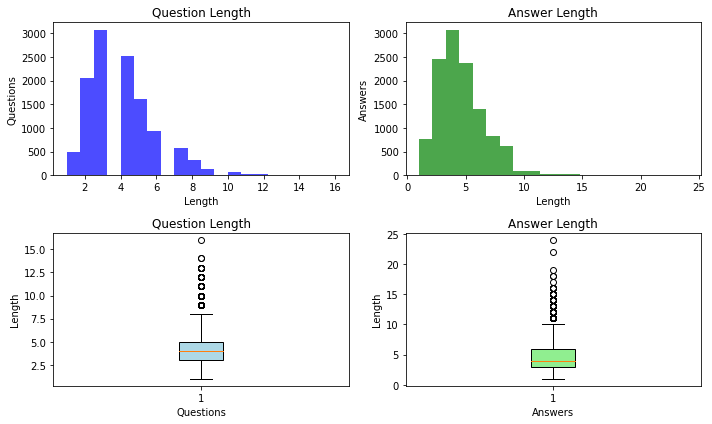

In [332]:
import matplotlib.pyplot as plt

# 각 문장의 길이를 계산하는 함수
def calculate_sentence_length(sentences):
    return [len(sentence.split()) for sentence in sentences]

# 질문과 답변의 길이 계산
question_lengths = calculate_sentence_length(questions)
answer_lengths = calculate_sentence_length(answers)

# 길이 시각화
plt.figure(figsize=(10, 6))

# 질문 길이 분포 히스토그램
plt.subplot(2, 2, 1)
plt.hist(question_lengths, bins=20, color='blue', alpha=0.7)
plt.title('Question Length')
plt.xlabel('Length')
plt.ylabel('Questions')

# 답변 길이 분포 히스토그램
plt.subplot(2, 2, 2)
plt.hist(answer_lengths, bins=20, color='green', alpha=0.7)
plt.title('Answer Length')
plt.xlabel('Length')
plt.ylabel('Answers')

# 질문 길이 박스플롯
plt.subplot(2, 2, 3)
plt.boxplot(question_lengths, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Question Length')
plt.xlabel('Questions')
plt.ylabel('Length')

# 답변 길이 박스플롯
plt.subplot(2, 2, 4)
plt.boxplot(answer_lengths, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Answer Length')
plt.xlabel('Answers')
plt.ylabel('Length')

plt.tight_layout()
plt.show()

In [333]:
# 최대 시퀀스 길이 설정
MAX_LENGTH = 25

In [334]:
def tokenize_and_filter(input_sentences, output_sentences):
    inputs = []
    for (sentence1, sentence2) in zip(input_sentences, output_sentences):
        # 시작 토큰 + 질문 + 구분 토큰 + 답변 + 종료 토큰
        sentence = (
            START_TOKEN +
            tokenizer.encode(sentence1) +
            SEP_TOKEN +
            tokenizer.encode(sentence2) +
            END_TOKEN
        )
        if len(sentence) <= MAX_LENGTH:
            inputs.append(sentence)
    # 패딩
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        inputs, maxlen=MAX_LENGTH, padding='post')
    return inputs

tokenized_inputs = tokenize_and_filter(questions, answers)

In [335]:
# 입력과 타겟 시퀀스 생성
x = tokenized_inputs[:, :-1]
y = tokenized_inputs[:, 1:]

print('입력 시퀀스의 크기(shape) :', x.shape)
print('타겟 시퀀스의 크기(shape) :', y.shape)

입력 시퀀스의 크기(shape) : (11693, 24)
타겟 시퀀스의 크기(shape) : (11693, 24)


In [336]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 03. 모델 구조 정의

In [337]:
# 하이퍼파라미터 설정
NUM_LAYERS = 12
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0
MAX_SEQ_LEN = MAX_LENGTH

# 모델 생성
model = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_seq_len=MAX_SEQ_LEN,
    name="gpt_model"
)

model.summary()


Model: "gpt_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, None, 256)    2089984     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_12 (TFOpLambda (None, None, 256)    0           embedding_24[0][0]               
__________________________________________________________________________________________________
positional_embedding_12 (Positi (None, None, 256)    6400        tf.math.multiply_12[0][0]        
__________________________________________________________________________________________

In [338]:
# 손실 함수 및 옵티마이저 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [339]:
# 학습률 스케줄러 정의
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [340]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 04. 모델 학습

In [341]:
# 모델 학습
EPOCHS = 12

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/12
183/183 [==============================] - 37s 153ms/step - loss: 4.5252 - accuracy: 0.0925
Epoch 2/12
183/183 [==============================] - 28s 155ms/step - loss: 3.7262 - accuracy: 0.1581
Epoch 3/12
183/183 [==============================] - 28s 152ms/step - loss: 2.7386 - accuracy: 0.2259
Epoch 4/12
183/183 [==============================] - 28s 153ms/step - loss: 1.9344 - accuracy: 0.3150
Epoch 5/12
183/183 [==============================] - 28s 154ms/step - loss: 1.3224 - accuracy: 0.4240
Epoch 6/12
183/183 [==============================] - 28s 153ms/step - loss: 0.8497 - accuracy: 0.5022
Epoch 7/12
183/183 [==============================] - 28s 153ms/step - loss: 0.5040 - accuracy: 0.5384
Epoch 8/12
183/183 [==============================] - 28s 153ms/step - loss: 0.2612 - accuracy: 0.5467
Epoch 9/12
183/183 [==============================] - 28s 153ms/step - loss: 0.1192 - accuracy: 0.5474
Epoch 10/12
183/183 [==============================] - 28s 153ms/step - l

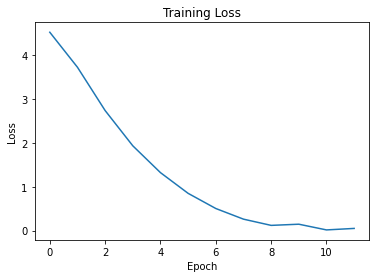

In [352]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 05. 모델 평가 -> 정성적 평가

In [371]:
# 평가 함수 및 답변 생성 함수 정의
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    input_ids = START_TOKEN + tokenizer.encode(sentence) + SEP_TOKEN
    input_ids = tf.expand_dims(input_ids, axis=0)  # (1, seq_len)

    for i in range(MAX_LENGTH):
        # 모델 예측
        predictions = model(input_ids, training=False)  # (1, seq_len, vocab_size)

        # 마지막 단어의 예측 결과 추출
        predictions = predictions[:, -1:, :]  # (1, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)  # (1, 1)
        predicted_id = tf.cast(predicted_id, tf.int32)

        # 종료 조건 확인
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측된 단어를 입력 시퀀스에 추가
        input_ids = tf.concat([input_ids, predicted_id], axis=-1)  # (1, seq_len+1)

    # 시작 토큰과 입력 문장 부분을 제거하여 출력 시퀀스 추출
    output = tf.squeeze(input_ids, axis=0)
    output = output.numpy().tolist()

    # [START_TOKEN] + 입력 문장 + [SEP_TOKEN]의 길이 계산
    input_length = len(START_TOKEN + tokenizer.encode(sentence) + SEP_TOKEN)

    # 출력 시퀀스에서 입력 시퀀스를 제외한 부분만 추출
    predicted_sequence = output[input_length:]

    return predicted_sequence

In [372]:
def Q1(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력: {}'.format(sentence))
    print('출력: {}'.format(predicted_sentence))

    return predicted_sentence

In [373]:
Q1('안녕하세요')

입력: 안녕하세요
출력: 이제 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 


'이제 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 는 '

In [374]:
Q1('오늘 저녁은 뭐야')

입력: 오늘 저녁은 뭐야
출력: 인 더  .는  .는  .는  .는  .는  .는  .는  .는  .는  .는  .는 


'인 더  .는  .는  .는  .는  .는  .는  .는  .는  .는  .는  .는 '

## 모델의 구조와 학습 단계 캡처

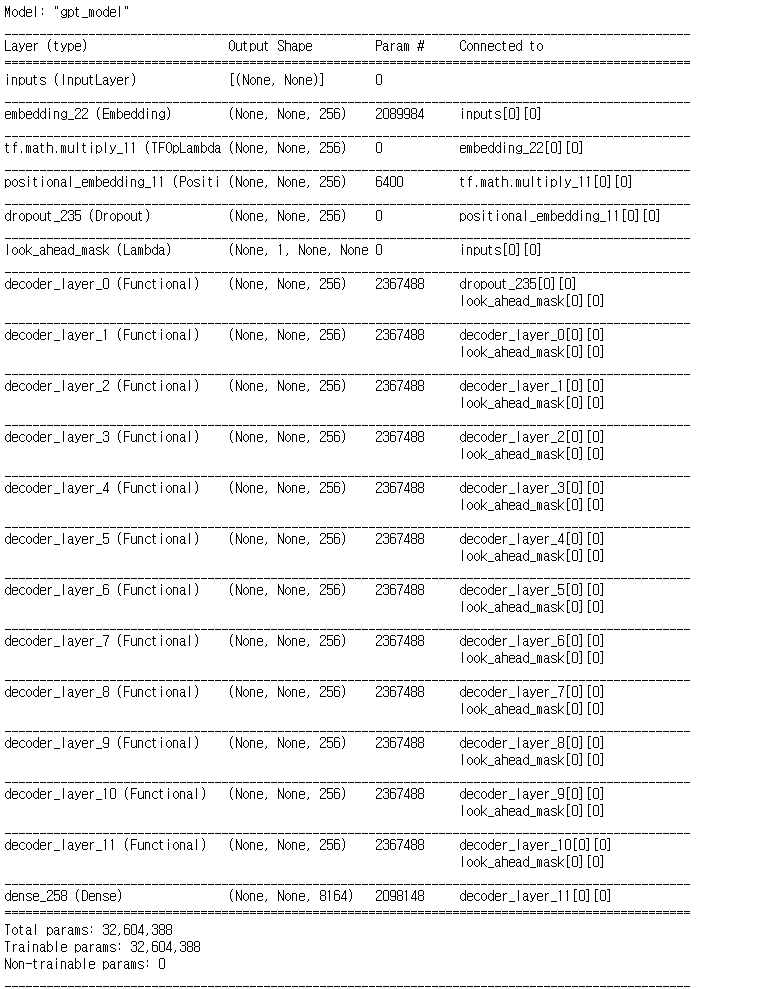

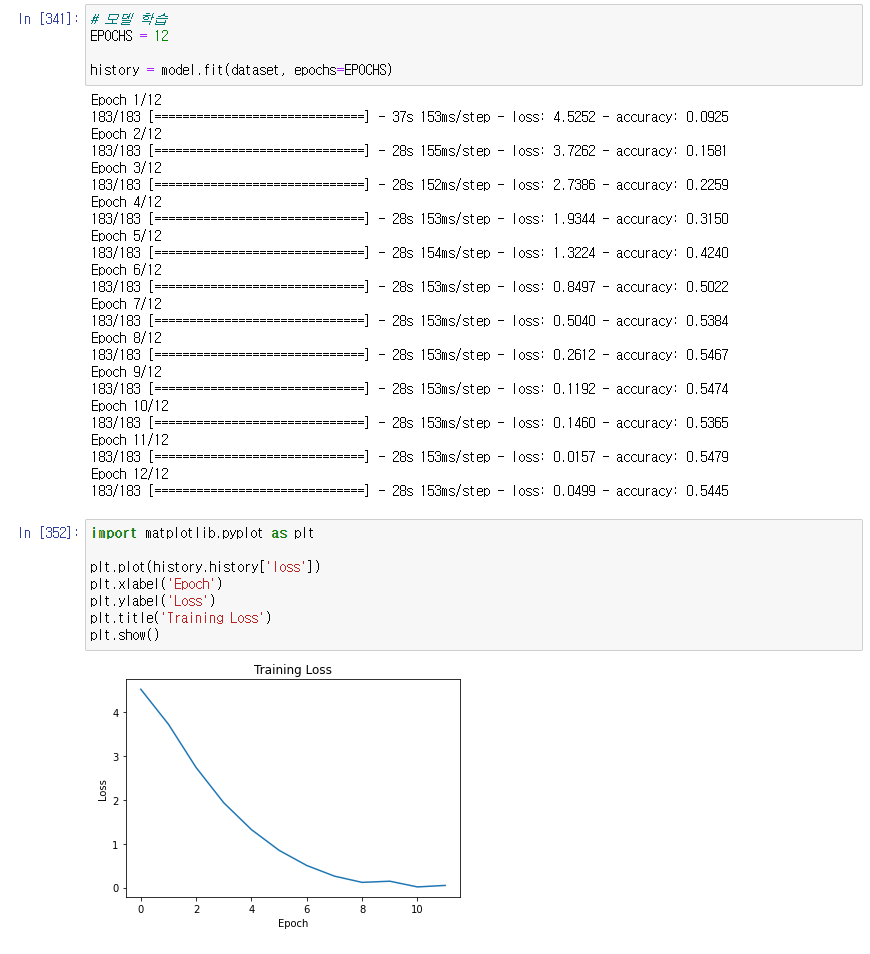

## 직접 구현하려니까 너무 어렵네요..

In [346]:
# 예시 문장
sentence = '오늘 저녁은 뭐야'

# 토큰화 확인
encoded = tokenizer.encode(sentence)
decoded = tokenizer.decode(encoded)

print('원본 문장:', sentence)
print('인코딩된 토큰:', encoded)
print('디코딩된 문장:', decoded)

원본 문장: 오늘 저녁은 뭐야
인코딩된 토큰: [76, 6284, 33, 641]
디코딩된 문장: 오늘 저녁은 뭐야


In [348]:
print('입력 시퀀스 샘플:', x[0])
print('타겟 시퀀스 샘플:', y[0])

입력 시퀀스 샘플: [8161 7900 4201 3052   42 8163 3838   74 7882    1 8162    0    0    0
    0    0    0    0    0    0    0    0    0    0]
타겟 시퀀스 샘플: [7900 4201 3052   42 8163 3838   74 7882    1 8162    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [353]:
def evaluate_debug(sentence):
    sentence = preprocess_sentence(sentence)
    input_ids = START_TOKEN + tokenizer.encode(sentence) + SEP_TOKEN
    input_ids = tf.expand_dims(input_ids, axis=0)  # (1, seq_len)

    output = input_ids  # 초기 입력 시퀀스

    for i in range(MAX_LENGTH):
        predictions = model(output, training=False)  # (1, seq_len, vocab_size)
        predictions = predictions[:, -1, :]  # (1, vocab_size)

        predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int32)  # (1,)

        if predicted_id == END_TOKEN[0]:
            break

        output = tf.concat([output, tf.expand_dims(predicted_id, 0)], axis=-1)  # (1, seq_len)

    predicted_sequence = output.numpy()[0]
    print('전체 생성된 시퀀스:', predicted_sequence)
    predicted_sequence = predicted_sequence[len(input_ids[0]):]  # 입력 부분 제외

    return predicted_sequence

In [354]:
prediction = evaluate_debug('오늘 저녁은 뭐야')
predicted_sentence = tokenizer.decode(
    [i for i in prediction if i < tokenizer.vocab_size])

print('예측된 문장:', predicted_sentence)

전체 생성된 시퀀스: [8161   76 6284   33  641 8163 8163  172    7    1   10    1   10    1
   10    1   10    1   10    1   10    1   10    1   10    1   10    1
   10    1   10]
예측된 문장: 인 더  .는  .는  .는  .는  .는  .는  .는  .는  .는  .는  .는 
